<h2> Time Series Prediction of Traffic </h2>

<b> Business Case </b>

Unicorn Investors wants to make an investment in a new form of transportation - JetRail. JetRail uses Jet propulsion technology to run rails and move people at a high speed! The investment would only make sense, if they can get more than 1 Million monthly users with in next 18 months. In order to help Unicorn Ventures in their decision, you need to forecast the traffic on JetRail for the next 7 months. You are provided with traffic data of JetRail since inception in the test file.

<b> Hypotheses </b>

- There will be an increase in the traffic as the years pass by.
    Explanation - Population has a general upward trend with time, so I can expect more people to travel by JetRail. Also,
    generally companies expand their businesses over time leading to more customers travelling through JetRail.
- The traffic will be high from May to October.
    Explanation - Tourist visits generally increases during this time perion.
- Traffic on weekdays will be more as compared to weekends/holidays.
    Explanation - People will go to office on weekdays and hence the traffic will be more
- Traffic during the peak hours will be high.
    Explanation - People will travel to work, college.

<b> Importing and loading data </b>

In [1]:
import pandas as pd          
import numpy as np      
import matplotlib.pyplot as plt 
from datetime import datetime
from pandas import Series

%matplotlib inline 

In [3]:
train=pd.read_csv("./data/Train.csv") 
test=pd.read_csv("./data/Test.csv")
train

<b> Exploratory Data Analysis and Feature Engineering </b>

In [4]:
train.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 3 columns):
ID          18288 non-null int64
Datetime    18288 non-null object
Count       18288 non-null int64
dtypes: int64(2), object(1)
memory usage: 428.7+ KB


In [7]:
# transform date time column
train['Datetime'] = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
test['Datetime'] = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 

In [8]:
# extract datetime objects
for i in (train, test):
    i['year']=i.Datetime.dt.year 
    i['month']=i.Datetime.dt.month 
    i['day']=i.Datetime.dt.day
    i['Hour']=i.Datetime.dt.hour 

In [9]:
# day of week
train['day of week']=train['Datetime'].dt.dayofweek 
temp = train['Datetime']

In [10]:
# extract weekend
def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0 
temp2 = train['Datetime'].apply(applyer) 
train['weekend']=temp2

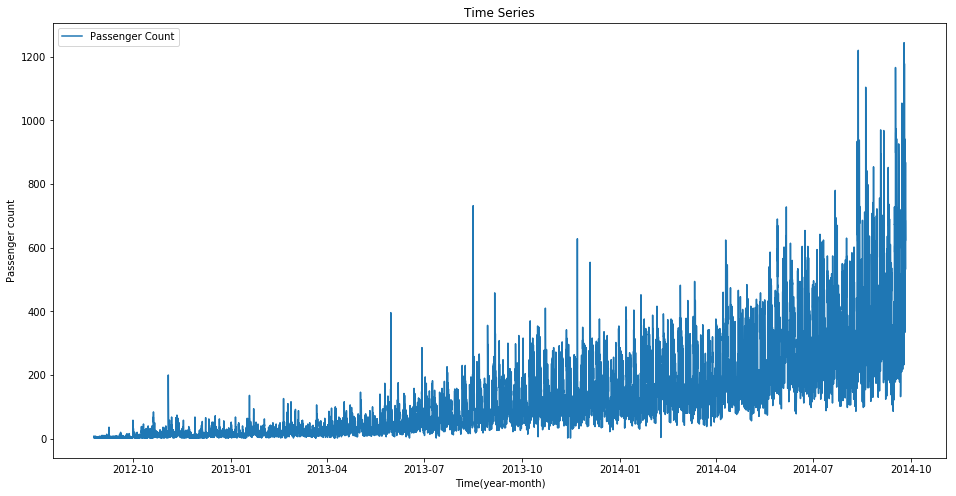

In [11]:
# plot the time series
train.index = train['Datetime'] 
df=train.drop('ID',1)
ts = df['Count'] 

plt.figure(figsize=(16,8)) 
plt.plot(ts, label='Passenger Count') 
plt.title('Time Series') 
plt.xlabel("Time(year-month)") 
plt.ylabel("Passenger count") 
plt.legend(loc='best')

Here we can infer that there is an increasing trend in the series, i.e., the number of count is increasing with respect to time. We can also see that at certain points there is a sudden increase in the number of counts. The possible reason behind this could be that on particular day, due to some event the traffic was high.

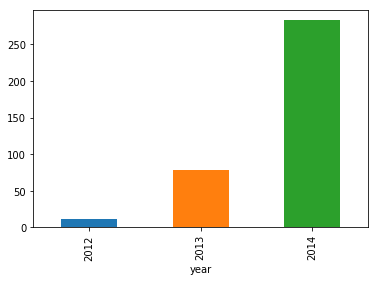

In [12]:
# yearly passenger count
train.groupby('year')['Count'].mean().plot.bar()

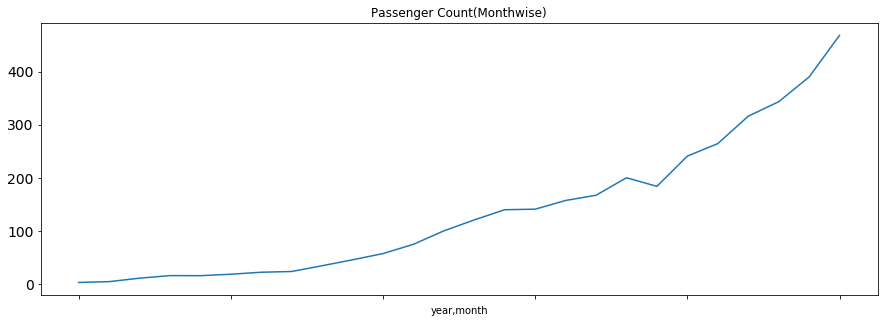

In [14]:
# passenger count and month
temp=train.groupby(['year', 'month'])['Count'].mean() 
temp.plot(figsize=(15,5), title= 'Passenger Count(Monthwise)', fontsize=14)

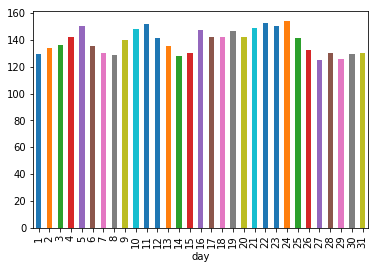

In [15]:
# daily mean of passenger count
train.groupby('day')['Count'].mean().plot.bar()

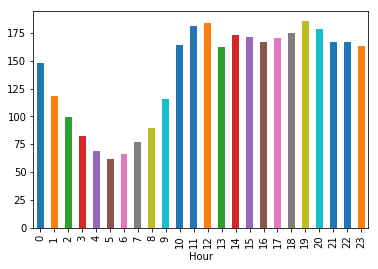

In [17]:
# mean of hourly passenger count
train.groupby('Hour')['Count'].mean().plot.bar()

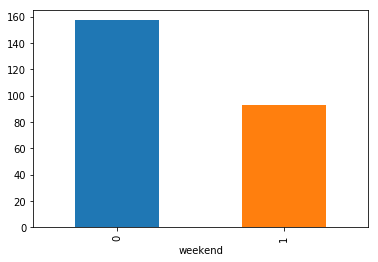

In [18]:
# passenger count weekdays vs weekend
train.groupby('weekend')['Count'].mean().plot.bar()

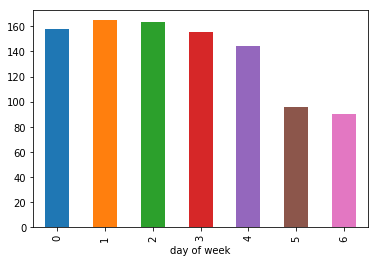

In [19]:
# day wise passenger count
train.groupby('day of week')['Count'].mean().plot.bar()

In [20]:
# drop ID
train=train.drop('ID',1)

As we have seen that there is a lot of noise in the hourly time series, we will aggregate the hourly time series to daily, weekly, and monthly time series to reduce the noise and make it more stable and hence would be easier for a model to learn.

In [21]:
train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp 

# Hourly time series 
hourly = train.resample('H').mean()

# Converting to daily mean 
daily = train.resample('D').mean() 

# Converting to weekly mean 
weekly = train.resample('W').mean() 

# Converting to monthly mean 
monthly = train.resample('M').mean()

C:\Users\A666524\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


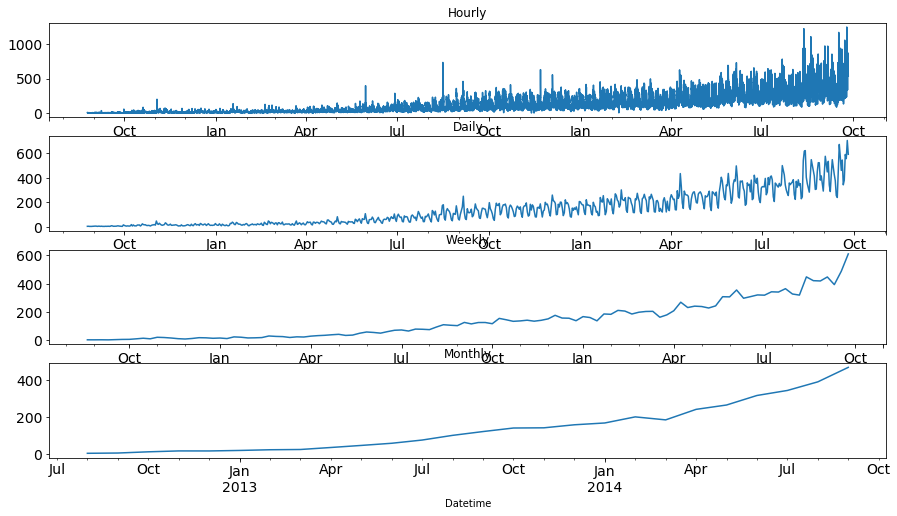

In [23]:
fig, axs = plt.subplots(4,1) 
hourly.Count.plot(figsize=(15,8), title= 'Hourly', fontsize=14, ax=axs[0]) 
daily.Count.plot(figsize=(15,8), title= 'Daily', fontsize=14, ax=axs[1]) 
weekly.Count.plot(figsize=(15,8), title= 'Weekly', fontsize=14, ax=axs[2]) 
monthly.Count.plot(figsize=(15,8), title= 'Monthly', fontsize=14, ax=axs[3]) 

plt.show()

It would be difficult to convert the monthly and weekly predictions to hourly predictions, as first we have to convert the monthly predictions to weekly, weekly to daily and daily to hourly predictions, which will become very expanded process. So, we will work on the daily time series.

In [25]:
test.Timestamp = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test.index = test.Timestamp  

# Converting to daily mean 
test = test.resample('D').mean() 

train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp 

# Converting to daily mean 
train = train.resample('D').mean()

C:\Users\A666524\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


<b> Model training and fitting </b>

Now we will divide our data in train and validation. We will make a model on the train part and predict on the validation part to check the accuracy of our predictions.

NOTE - It is always a good practice to create a validation set that can be used to assess our models locally. If the validation metric(rmse) is changing in proportion to public leaderboard score, this would imply that we have chosen a stable validation technique.

To divide the data into training and validation set, we will take last 3 months as the validation data and rest for training data. We will take only 3 months as the trend will be the most in them. If we take more than 3 months for the validation set, our training set will have less data points as the total duration is of 25 months. So, it will be a good choice to take 3 months for validation set.

The starting date of the dataset is 25-08-2012 as we have seen in the exploration part and the end date is 25-09-2014.

In [27]:
Train=train.ix['2012-08-25':'2014-06-24'] 
valid=train.ix['2014-06-25':'2014-09-25']

C:\Users\A666524\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
C:\Users\A666524\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


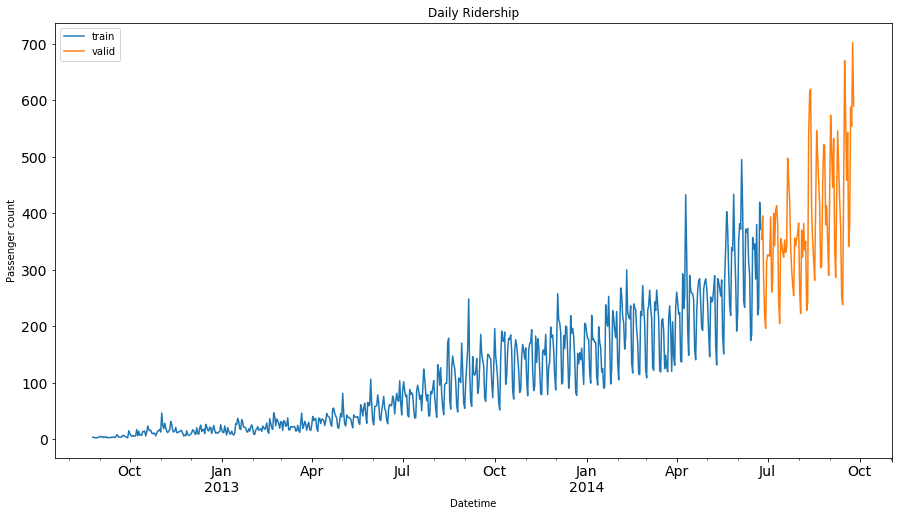

In [29]:
# plot train and validation set
Train.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='train') 
valid.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='valid') 

plt.xlabel("Datetime") 
plt.ylabel("Passenger count") 
plt.legend(loc='best') 
plt.show()

Naive approach

In this forecasting technique, we assume that the next expected point is equal to the last observed point. So we can expect a straight horizontal line as the prediction.

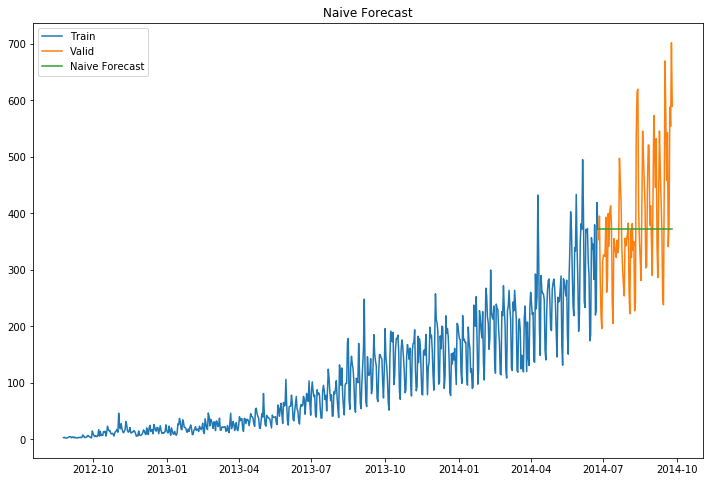

In [30]:
dd= np.asarray(Train.Count) 
y_hat = valid.copy() 
y_hat['naive'] = dd[len(dd)-1] 

plt.figure(figsize=(12,8)) 
plt.plot(Train.index, Train['Count'], label='Train') 
plt.plot(valid.index,valid['Count'], label='Valid') 
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast') 
plt.legend(loc='best') 
plt.title("Naive Forecast") 
plt.show()

In [31]:
# calculate RMSE
from sklearn.metrics import mean_squared_error 
from math import sqrt 
rms = sqrt(mean_squared_error(valid.Count, y_hat.naive)) 
print(rms)

111.79050467496724


Moving Average

In this technique we will take the average of the passenger counts for last few time periods only.

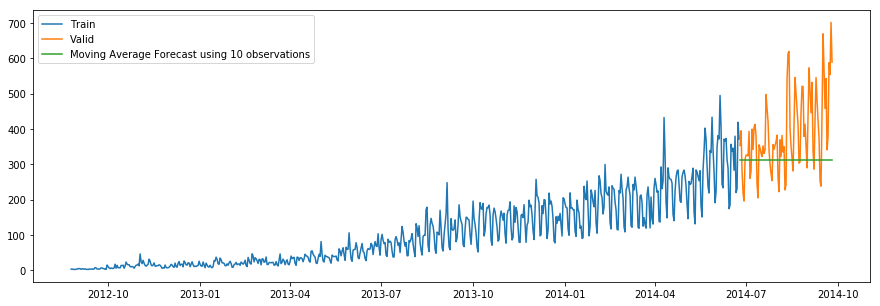

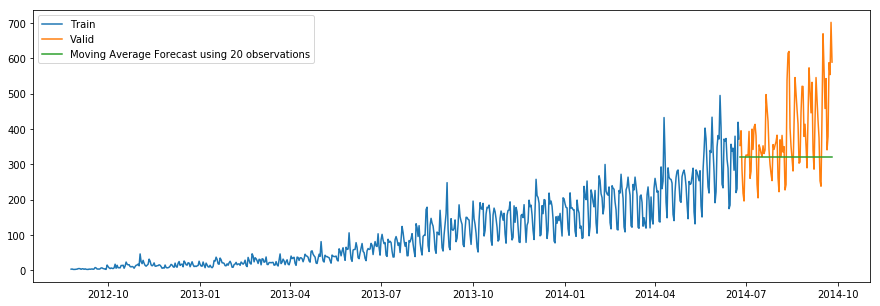

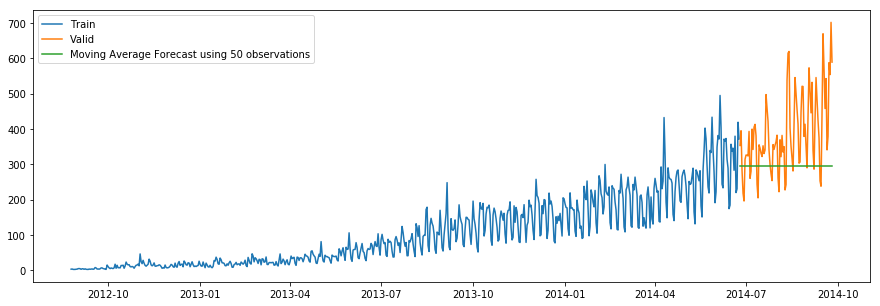

In [33]:
# 10 observations MA
y_hat_avg = valid.copy() 
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(10).mean().iloc[-1] # average of last 10 observations. 
plt.figure(figsize=(15,5)) 
plt.plot(Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 10 observations') 
plt.legend(loc='best') 
plt.show() 

# 20 observations MA
y_hat_avg = valid.copy() 
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(20).mean().iloc[-1] # average of last 20 observations. 
plt.figure(figsize=(15,5)) 
plt.plot(Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 20 observations') 
plt.legend(loc='best') 
plt.show() 

# 50 observations MA
y_hat_avg = valid.copy() 
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(50).mean().iloc[-1] # average of last 50 observations. 
plt.figure(figsize=(15,5)) 
plt.plot(Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 50 observations') 
plt.legend(loc='best') 
plt.show()

In [35]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.moving_avg_forecast)) 
print(rms)

# predictions get weaker with more observations

144.19175679986802


Simple Exponential Smoothing

In this technique, we assign larger weights to more recent observations than to observations from the distant past.
The weights decrease exponentially as observations come from further in the past, the smallest weights are associated with the oldest observations.

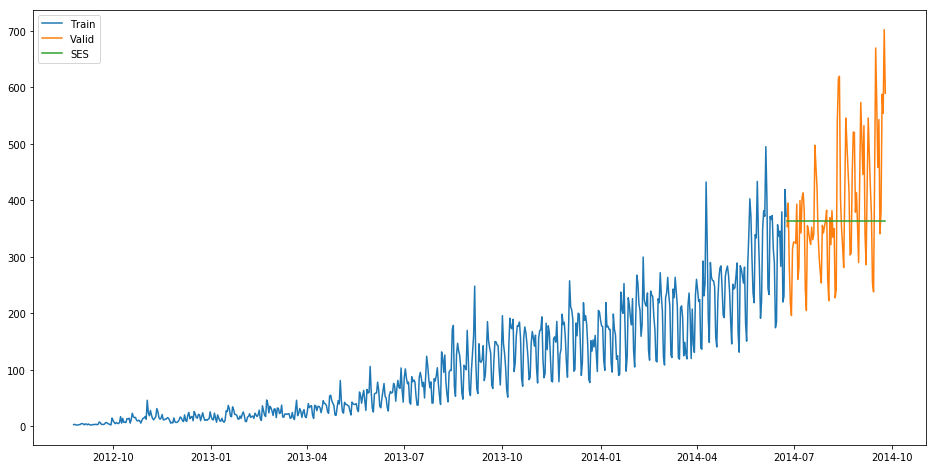

In [36]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt 
y_hat_avg = valid.copy() 
fit2 = SimpleExpSmoothing(np.asarray(Train['Count'])).fit(smoothing_level=0.6,optimized=False) 
y_hat_avg['SES'] = fit2.forecast(len(valid)) 

plt.figure(figsize=(16,8)) 
plt.plot(Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['SES'], label='SES') 
plt.legend(loc='best') 
plt.show()

In [37]:
# calculate RMSE
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.SES)) 
print(rms)

113.43708111884514


Holts Linear Trend Model

It is an extension of simple exponential smoothing to allow forecasting of data with a trend.
This method takes into account the trend of the dataset. The forecast function in this method is a function of level and trend.

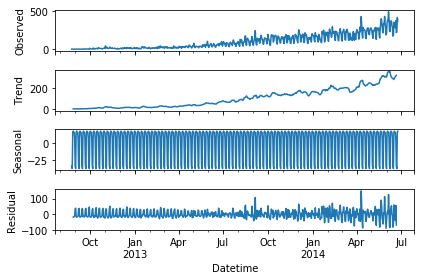

In [39]:
# visualized observed, Trend, seasonal and residual
import statsmodels.api as sm 
sm.tsa.seasonal_decompose(Train.Count).plot() 
result = sm.tsa.stattools.adfuller(train.Count) 
plt.show()

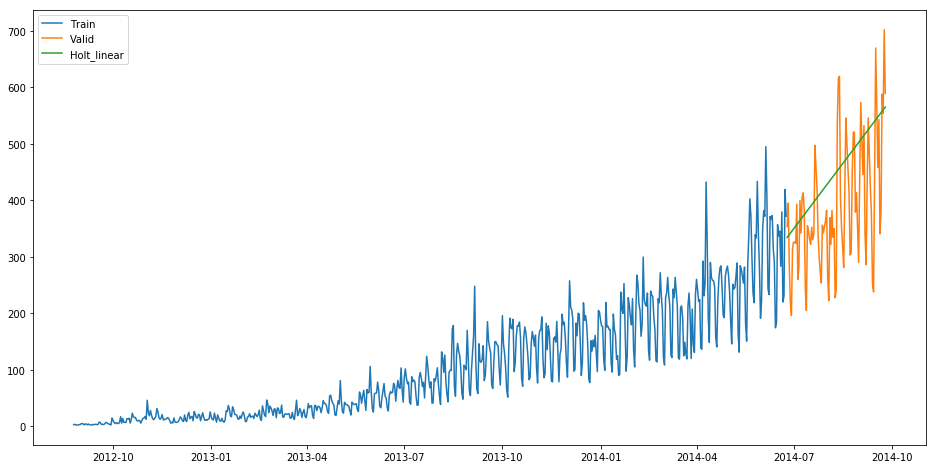

In [40]:
# build a model with Holt
y_hat_avg = valid.copy() 
fit1 = Holt(np.asarray(Train['Count'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1) 
y_hat_avg['Holt_linear'] = fit1.forecast(len(valid)) 

plt.figure(figsize=(16,8)) 
plt.plot(Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear') 
plt.legend(loc='best') 
plt.show()

In [41]:
# rmse
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.Holt_linear)) 
print(rms)

112.94278345314041


Holt Winters Model

Datasets which show a similar set of pattern after fixed intervals of a time period suffer from seasonality.

The above mentioned models don’t take into account the seasonality of the dataset while forecasting. Hence we need a method that takes into account both trend and seasonality to forecast future prices.

One such algorithm that we can use in such a scenario is Holt’s Winter method. The idea behind Holt’s Winter is to apply exponential smoothing to the seasonal components in addition to level and trend.

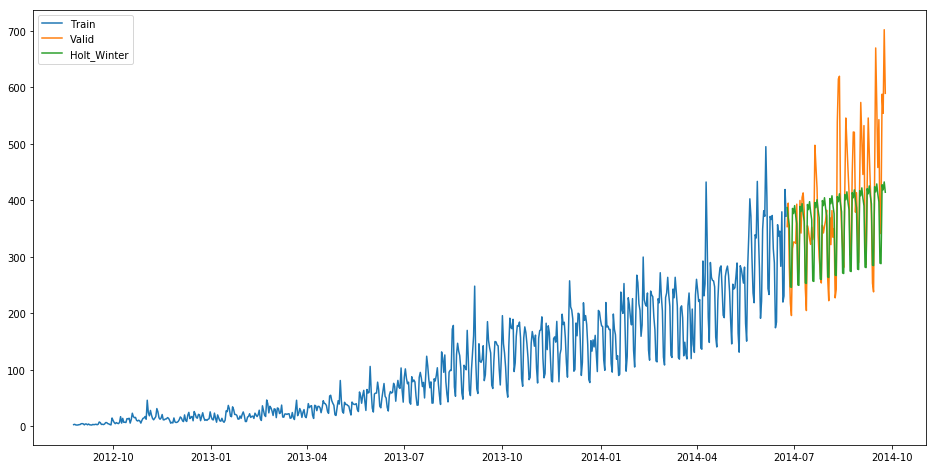

In [42]:
y_hat_avg = valid.copy() 
fit1 = ExponentialSmoothing(np.asarray(Train['Count']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit() 
y_hat_avg['Holt_Winter'] = fit1.forecast(len(valid)) 

plt.figure(figsize=(16,8)) 
plt.plot( Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter') 
plt.legend(loc='best') 
plt.show()

In [43]:
# calculate RMSE
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.Holt_Winter)) 
print(rms)

82.37467736825413


ARIMA

ARIMA stands for Auto Regression Integrated Moving Average. It is specified by three ordered parameters (p,d,q).

Here p is the order of the autoregressive model(number of time lags)
d is the degree of differencing(number of times the data have had past values subtracted)
q is the order of moving average model.

The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation.

There are three basic criterion for a series to be classified as stationary series :

- The mean of the time series should not be a function of time. It should be constant.
- The variance of the time series should not be a function of time.
- The covariance of the ith term and the (i+m)th term should not be a function of time.

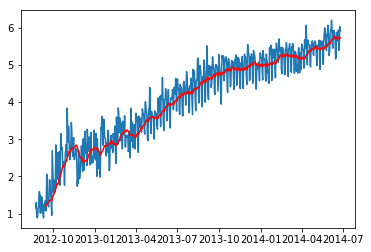

In [46]:
# removing trend
Train_log = np.log(Train['Count']) 
valid_log = np.log(valid['Count'])
moving_avg = Train_log.rolling(24).mean()

plt.plot(Train_log) 
plt.plot(moving_avg, color = 'red') 
plt.show()

train_log_moving_avg_diff = Train_log - moving_avg
train_log_moving_avg_diff.dropna(inplace = True)
train_log_diff = Train_log - Train_log.shift(1) 

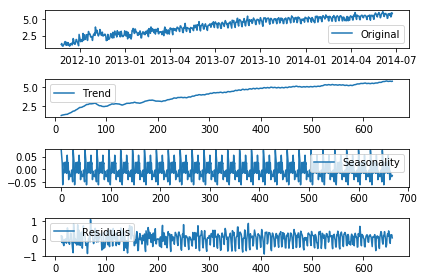

In [48]:
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposition = seasonal_decompose(pd.DataFrame(Train_log).Count.values, freq = 24) 

trend = decomposition.trend 
seasonal = decomposition.seasonal 
residual = decomposition.resid 

plt.subplot(411) 
plt.plot(Train_log, label='Original') 
plt.legend(loc='best') 
plt.subplot(412) 
plt.plot(trend, label='Trend') 
plt.legend(loc='best') 
plt.subplot(413) 
plt.plot(seasonal,label='Seasonality') 
plt.legend(loc='best') 
plt.subplot(414) 
plt.plot(residual, label='Residuals') 
plt.legend(loc='best') 
plt.tight_layout() 
plt.show()

# residuals are stationary

To find the optimized values of these parameters, we will use ACF(Autocorrelation Function) and PACF(Partial Autocorrelation Function) graph.

ACF is a measure of the correlation between the TimeSeries with a lagged version of itself.

PACF measures the correlation between the TimeSeries with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons.

In [51]:
from statsmodels.tsa.stattools import acf, pacf 
lag_acf = acf(train_log_diff.dropna(), nlags=25) 
lag_pacf = pacf(train_log_diff.dropna(), nlags=25, method='ols')

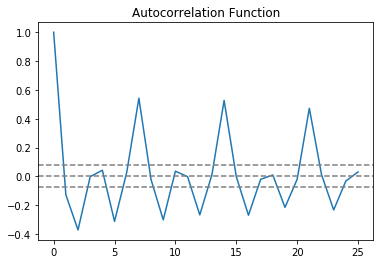

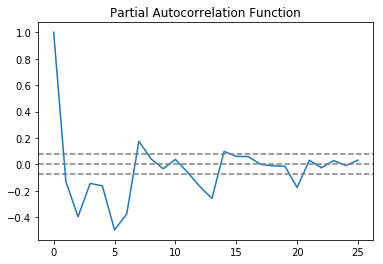

In [53]:
# ACF and PACF plot
plt.plot(lag_acf) 
plt.axhline(y=0,linestyle='--',color='gray') 
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.title('Autocorrelation Function') 
plt.show() 

plt.plot(lag_pacf) 
plt.axhline(y=0,linestyle='--',color='gray') 
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function') 
plt.show()

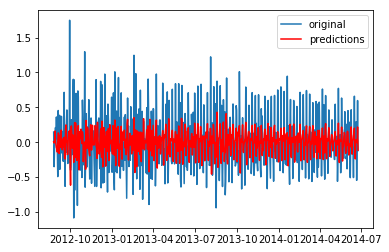

In [54]:
#AR model
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(Train_log, order=(2, 1, 0))  # here the q value is zero since it is just the AR model 
results_AR = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(), label='original') 
plt.plot(results_AR.fittedvalues, color='red', label='predictions') 
plt.legend(loc='best') 
plt.show()

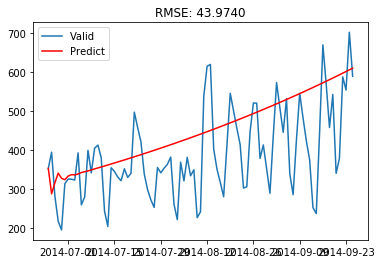

In [56]:
AR_predict=results_AR.predict(start="2014-06-25", end="2014-09-25") 
AR_predict=AR_predict.cumsum().shift().fillna(0) 
AR_predict1=pd.Series(np.ones(valid.shape[0]) * np.log(valid['Count'])[0], index = valid.index) 
AR_predict1=AR_predict1.add(AR_predict,fill_value=0) 
AR_predict = np.exp(AR_predict1)

plt.plot(valid['Count'], label = "Valid") 
plt.plot(AR_predict, color = 'red', label = "Predict") 
plt.legend(loc= 'best') 
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(AR_predict, valid['Count']))/valid.shape[0])) 
plt.show()


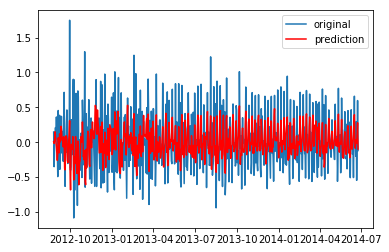

In [57]:
# MA model
model = ARIMA(Train_log, order=(0, 1, 2))  # here the p value is zero since it is just the MA model 
results_MA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(), label='original') 
plt.plot(results_MA.fittedvalues, color='red', label='prediction') 
plt.legend(loc='best') 
plt.show()

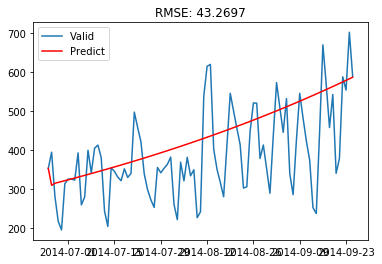

In [58]:
MA_predict=results_MA.predict(start="2014-06-25", end="2014-09-25") 
MA_predict=MA_predict.cumsum().shift().fillna(0) 
MA_predict1=pd.Series(np.ones(valid.shape[0]) * np.log(valid['Count'])[0], index = valid.index) 
MA_predict1=MA_predict1.add(MA_predict,fill_value=0) 
MA_predict = np.exp(MA_predict1)

plt.plot(valid['Count'], label = "Valid") 
plt.plot(MA_predict, color = 'red', label = "Predict") 
plt.legend(loc= 'best') 
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(MA_predict, valid['Count']))/valid.shape[0])) 
plt.show()

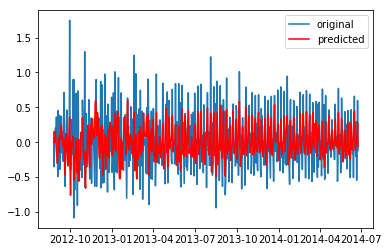

In [59]:
# combined
model = ARIMA(Train_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(),  label='original') 
plt.plot(results_ARIMA.fittedvalues, color='red', label='predicted') 
plt.legend(loc='best') 
plt.show()

In [60]:
def check_prediction_diff(predict_diff, given_set):
    predict_diff= predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(np.ones(given_set.shape[0]) * np.log(given_set['Count'])[0], index = given_set.index)
    predict_log = predict_base.add(predict_diff,fill_value=0)
    predict = np.exp(predict_log)

    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))
    plt.show()

def check_prediction_log(predict_log, given_set):
    predict = np.exp(predict_log)
 
    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))
    plt.show()

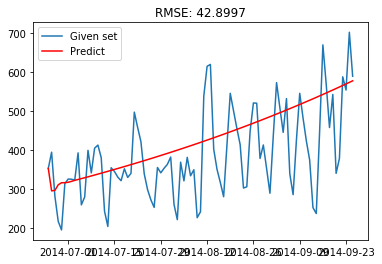

In [61]:
ARIMA_predict_diff=results_ARIMA.predict(start="2014-06-25", end="2014-09-25")
check_prediction_diff(ARIMA_predict_diff, valid)

SARIMAX model

SARIMAX model takes into account the seasonality of the time series. So we will build a SARIMAX model on the time series.

C:\Users\A666524\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


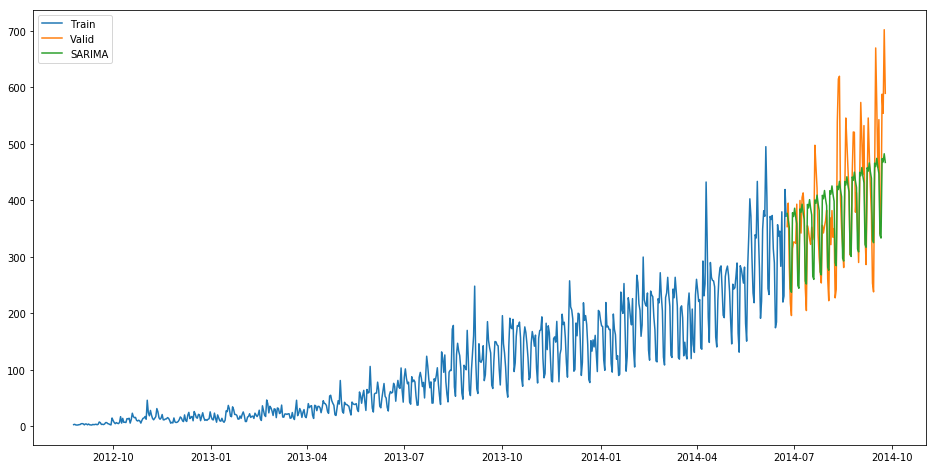

In [62]:
import statsmodels.api as sm
y_hat_avg = valid.copy() 
fit1 = sm.tsa.statespace.SARIMAX(Train.Count, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit() 
y_hat_avg['SARIMA'] = fit1.predict(start="2014-6-25", end="2014-9-25", dynamic=True) 

plt.figure(figsize=(16,8)) 
plt.plot( Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['SARIMA'], label='SARIMA') 
plt.legend(loc='best') 
plt.show()

In [63]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.SARIMA)) 
print(rms)

69.6217913672619


What else can be tried to improve your model further?

Try to make a weekly time series and make predictions for that series and then distribute those predictions into daily and then hourly predictions.

Use combination of models(ensemble) to reduce the rmse.